# ChocoData

**Chocolate** is the food we all know and love. It dates back to the Olmec culture (19th-11th century BCE), and it has been consumed in some form by Maya and Aztecs too. Chocolate is consumed today more than ever and we advocate for consumer awareness concerning how chocolate is made. To this end, we explore some chocolate bar rating data, contained in the [Chocolate Bar Ratings](https://www.kaggle.com/rtatman/chocolate-bar-ratings) Kaggle dataset. The idea is to present, analyze, and compare the best chocolate bars throughout a visual data-analysis tour.

The `ChocoData` notebook is the exam project of the Ph.D. course **Data and Results Visualization**, held by Prof. Daniele Loiacono at Politecnico di Milano in December 2021. The authors are Loris Giulivi, Paolo Boffi, and Alberto Archetti. It is provided under the MIT license.

![testo del link](https://www.chocolate7.com/wp-content/uploads/2020/07/scopri_il_tuo_cioccolato_home.jpg)


## Index

* [Set up the stage](#setup)
    * [Imports](#imports)
    * [Download the dataset](#downloaddata)
    * [Helper functions](#helperfunctions)
    * [Data loading](#dataloading)
    * [Data cleaning](#datacleaning)
* [Summary statistics](#summary)
* [Ratings timeline](#ratings_timeline)
* [Companies](#companies)
    * [Companies per country](#comppercountry)
    * [Map of the companies](#mapcomp)
    * [Companies per number of reviews](#comprevs)
    * [Top-rated companies](#topcomp)
    * [Best company per country](#bestcomp)
    * [Map of the best companies per country ](#mapbestcomp)
* [Cocoa beans](#cocoa)
    * [Bean types distribution](#beandistrib)
    * [Ratings per bean type](#ratingsbean)
    * [Reviews per cocoa percent](#reviewsperc)
    * [Ratings cocoa percent](#ratingsperc)
    * [Bean imports by country](#beanimports)
    * [Top-rated bean exporters](#beanexports)
    


<a name="setup"></a>
## Set up the stage

In this section, we import the main plotting libraries, `seaborn` and `matplotlib` and prepare the dataset for further processing. We fix duplicate, wrong, and missing values. Finally, we define some helper functions that will be useful later.

Note: you run the Imports cell twice and restart the runtime!

<a name="imports"></a>
### Imports

**IMPORTANT!!! RUN THIS CELL TWICE AND RESTART RUNTIME BECAUSE COLAB DOES NOT INSTALL THE CORRECT VERSION THE FIRST TIME**

In [ ]:
# !!!  Run this cell twice to solve dependencies  !!!

# Update matplotlib to the last available version; without this ax.bar_label 
# does not work (used to display bar values on seaborn barplots); every time 
# this line of code is executed for the first time, we need to restart the 
# runtime
! pip install matplotlib --upgrade matplotlib

# Requirements for folium maps
! pip install shapely
! pip install gdal
! pip install fiona
! pip install pyproj
! pip install six
! pip install rtree
! pip install geopandas
! pip install folium --upgrade folium

# Requirements to get shareable google drive links
!apt-get install xattr > /dev/null

In [2]:
import os
from os import path
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import geopandas
import folium
import csv
import math
import ipywidgets as widgets
from IPython.display import display
from shapely.geometry import shape
from subprocess import getoutput
from IPython.display import HTML
from google.colab import drive
import branca
from branca.element import Figure
import pickle
import matplotlib.ticker as ticker

sns.set_theme(style="darkgrid")

if not os.path.exists('images'):
    os.mkdir('images')

if not os.path.exists('images/companies'):
    os.mkdir('images/companies')

if not os.path.exists('images/cocoa_beans'):
    os.mkdir('images/cocoa_beans')

In [3]:
# Enable colorblind mode
COLORBLIND = True

<a name="downloaddata"></a>
### Download the dataset

In [ ]:
# Download and extract the dataset; the flavors_of_cacao.csv file is now 
# available locally
!wget -nc https://www.dropbox.com/sh/duqeg9dx2o8s18r/AAAX_rCz1dwN8rs1LMwH1Jg1a
!mv AAAX_rCz1dwN8rs1LMwH1Jg1a flavors_of_cacao.zip
!unzip -n flavors_of_cacao.zip && rm -f flavors_of_cacao.zip

!wget "https://drive.google.com/uc?export=view&id=1gWIFCQsFIt8aI4xwI_FaGdFRkVWiCl_e" -O html_dic.txt
!wget "https://drive.google.com/uc?export=view&id=13-uATQyAAkrqdNkum1WZd-h3vk_HOavS" -O iminfo.txt


<a name="helperfunctions"></a>
### Helper functions

In [6]:
def get_palette(n=None, ordered=False, val_list=None, alt_color=False):
    """ Returns a color palette on n elements."""
    if not ordered:
        assert n is not None, 'You must provide the number of values!'
        palette = sns.color_palette('deep', n)
        if COLORBLIND:
            palette = sns.color_palette('colorblind', n)
    else:
        assert val_list is not None, 'You must provide a list of values!'
        min, max = np.min(val_list), np.max(val_list)
        val_list = (1.0 * (val_list - min) / (max - min) * 60).astype(np.uint32)
        cmap_func = branca.colormap.linear.Blues_09
        if alt_color:
            cmap_func = branca.colormap.linear.Greens_09
        colormap = cmap_func.scale(0, 100)
        palette = [colormap(x + 40) for x in val_list]
    return palette

def annotate_with_counts(ax):
    """Adds counts on top of a Seaborn countplot."""
    for p in ax.patches: 
        ax.annotate('{:d}'.format(p.get_height()), 
                    (p.get_x() + p.get_width() * 0.5, p.get_height() + 5), 
                    ha = 'center')
    return ax

def rename_axes(ax, xlabel, ylabel):
    """"Renames the axes of a plot."""
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return ax

def vocabularize(vocab_dict, force=False):
    """Returns a vocabularize function for Pandas `apply`."""
    def vocabularize_with_dict(x):
        for b in vocab_dict.keys():
            if x.find(b) != -1:
                return vocab_dict[b]
        if force:
            return 'Unknown'
        return x
    return vocabularize_with_dict

def save_plot(name, subfolder=None):
  """Save a plot with the specified name inside the specified subfolder"""
    name = name.replace(' ', '_').lower()
    if subfolder is not None:
        assert subfolder in ['companies', 'cocoa_beans'], 'Subfolder not valid!'
        plt.savefig('images/{}/{}.pdf'.format(subfolder, name), bbox_inches='tight')
        plt.savefig('images/{}/{}.png'.format(subfolder, name), bbox_inches='tight')
    else:
        plt.savefig('images/{}.pdf'.format(name), bbox_inches='tight')
        plt.savefig('images/{}.png'.format(name), bbox_inches='tight')

def get_shareable_link(file_path):
  fid = getoutput("xattr -p 'user.drive.id' " + "'" + file_path + "'")
  return "https://drive.google.com/uc?export=view&id=" + fid

def html_country(country):
    dimx=0
    dimy=0
    infofile = open(os.path.join(os.getcwd(), "/content/drive/MyDrive/colab/chocodata_images/iminfo.txt"))
    csv_file = csv.reader(infofile, delimiter=",")
    for row in csv_file:
        if row[0] == country:
            dimx = int(row[1])/4
            dimy = int(row[2])/4
            break
    infofile.close()

    if dimy==0:
      html = "No companies available for "+country
    else:
      url = get_shareable_link("/content/drive/MyDrive/colab/chocodata_images/best_companies_by_country/"+country+".png")
      html = "<img src='"+url+"' alt='chart' style='height:"+str(math.floor(dimy))+"px; width:"+str(math.floor(dimx))+"px'>"

    return html


<a name="dataloading"></a>
### Data loading

In [7]:
# Load the dataset
chocodata = pd.read_csv("flavors_of_cacao.csv")

# Rename columns
columns = ['company', 'bar_name', 'ref', 'review_date', 'cocoa_percent',
           'company_location', 'rating', 'bean_type', 'bean_origin']
chocodata = chocodata.rename(columns=dict(zip(chocodata.columns, columns)))

# Reorder columns
columns = ['bar_name', 'company', 'company_location', 'rating', 'ref', 
           'review_date', 'cocoa_percent', 'bean_type', 'bean_origin']
chocodata = chocodata[columns]

# Define data types
chocodata['cocoa_percent'] = chocodata['cocoa_percent'].apply(
    lambda x: float(str(x).strip('%')) * 0.01)
chocodata = chocodata.astype({
    'bar_name': str,
    'company': str, 
    'company_location': str, 
    'rating': float, 
    'ref': int, 
    'review_date': int,
    'cocoa_percent': float, 
    'bean_type': str, 
    'bean_origin': str
})

# Sort values by insert order in the dataset
chocodata = chocodata.sort_values(by=['ref', 'review_date', 'company'])

# Print the first 5 rows
chocodata.head()

,bar_name,company,company_location,rating,ref,review_date,cocoa_percent,bean_type,bean_origin
878,Trinatario Treasure,Jacque Torres,U.S.A.,2.00,5,2006,0.71,Trinitario,Ghana
1325,Sao Tome & Principe,Pralus,France,3.50,5,2006,0.75,Forastero,Sao Tome & Principe
1326,Trinidad,Pralus,France,3.50,5,2006,0.75,Trinitario,Trinidad
1327,"Madagascar, Nosy Be Isle.",Pralus,France,3.75,5,2006,0.75,Criollo,Madagascar
739,Dark,Green & Black's (ICAM),U.K.,2.50,15,2006,0.70,,


<a name="datacleaning"></a>
### Data cleaning

In this section, we perform some data cleaning operations:

1. We fix inconsistencies in country names,
2. We modify the `bean_type` column in order to limit its values to `Criollo`, `Forastero`, and `Trinitario`,
3. We convert any missing value to `Unknown`.

In [8]:
# Fix country names
country_dict = {
    'Amsterdam': 'Netherlands',
    'Eucador': 'Ecuador',
    'Niacragua': 'Nicaragua',
    'U.S.A.': 'United States of America',
    'Trinidad': 'Trinidad and Tobago',
    'Congo': 'Dem. Rep. Congo',
    'Dominican Republic': 'Dominican Rep.',
    'Domincan Republic': 'Dominican Rep.',
    'Solomon Islands': 'Solomon Is.'
}
chocodata['company_location'] = chocodata['company_location'].apply(
    vocabularize(country_dict))

# Fix bean types
bean_dict = {
    'Criollo': 'Criollo',
    'Forastero': 'Forastero',
    'Trinitario': 'Trinitario'
}
chocodata['bean_type'] = chocodata['bean_type'].apply(
    vocabularize(bean_dict, force=True))

# Fix bean origins
prod_dict = {
    'Trinidad': 'Trinidad and Tobago',
    'Trinidad, Tobago': 'Trinidad and Tobago',
    'Trinidad-Tobago': 'Trinidad and Tobago',
    'Tobago': 'Trinidad and Tobago',
    'Carribean': 'Caribbean',
    'Ghana': 'Ghana',
    'Venezuela': 'Venezuela',
    'Ven.': 'Venezuela',
    'Ven': 'Venezuela',
    'Venez': 'Venezuela',
    'Dominican Republic': 'Dominican Rep.',
    'Domincan Republic': 'Dominican Rep.',
    'Colombia': 'Colombia',
    'Ecuador': 'Ecuador',
    'Peru': 'Peru',
    'Peru(SMartin,Pangoa,nacional)': 'Peru',
    'South America': 'South America',
    'Principe': 'Sao Tome and Principe',
    'Haiti': 'Haiti',
    'Mad.': 'Madagascar',
    'Congo': 'Dem. Rep. Congo',
    'Amsterdam': 'Netherlands',
    'Solomon Islands': 'Solomon Is.'
}
chocodata['bean_origin'] = chocodata['bean_origin'].apply(
    vocabularize(prod_dict))

# Un-capitalize country names to be compliant with naming convention
chocodata['bean_origin'] = chocodata['bean_origin'].str.lower()
chocodata['company_location'] = chocodata['company_location'].str.lower()

# Substitute all the empty and NaN cells with 'Unknown'
for c in columns:
    chocodata[c] = chocodata[c].replace(r'^\s+$', 'Unknown', regex=True)
    chocodata[c] = chocodata[c].fillna('Unknown')

chocodata.head()

,bar_name,company,company_location,rating,ref,review_date,cocoa_percent,bean_type,bean_origin
878,Trinatario Treasure,Jacque Torres,united states of america,2.00,5,2006,0.71,Trinitario,ghana
1325,Sao Tome & Principe,Pralus,france,3.50,5,2006,0.75,Forastero,sao tome and principe
1326,Trinidad,Pralus,france,3.50,5,2006,0.75,Trinitario,trinidad and tobago
1327,"Madagascar, Nosy Be Isle.",Pralus,france,3.75,5,2006,0.75,Criollo,madagascar
739,Dark,Green & Black's (ICAM),u.k.,2.50,15,2006,0.70,Unknown,Unknown


<a name="summary"></a>
## Summary statistics

In this section, we describe the attributes of the dataset and provide an overall insight about its content using summary statistics.

In [9]:
# Define column descriptions
column_descriptions = {
    'bar_name': 'The bar name or the specific geo-region for the bar', 
    'company': 'Name of the company manufacturing the bar', 
    'company_location': 'Manufacturer base country', 
    'rating': 'Expert rating for the bar', 
    'ref': 'Review creation value. Higher = more recent', 
    'review_date': 'Date of publication of the review',
    'cocoa_percent': 'Cocoa percentage (darkness)', 
    'bean_type': 'The variety (breed) of bean used, if provided', 
    'bean_origin': 'The broad geo-region of origin for the bean'
}

# Count unique values of each column
chocodata_uniques = {}
for c in columns:
    chocodata_uniques[c] = chocodata[c].unique()

# Define a dictionary of columns paired with unique values and attribute 
# descriptions
unique_values = {'column': ['total_samples'], 
                 'unique_values': [chocodata.shape[0]],
                 'type': [type(chocodata.shape[0])],
                 'description': ['Total number of samples in the dataset']}
for c in columns:
    unique_values['column'].append(c)
    unique_values['unique_values'].append(len(chocodata_uniques[c]))
    unique_values['type'].append(type(chocodata[c][0]))
    unique_values['description'].append(column_descriptions[c])

# Convert dictionary to DataFrame
unique_values = pd.DataFrame(unique_values)
unique_values

,column,unique_values,type,description
0,total_samples,1795,<class 'int'>,Total number of samples in the dataset
1,bar_name,1039,<class 'str'>,The bar name or the specific geo-region for th...
2,company,416,<class 'str'>,Name of the company manufacturing the bar
3,company_location,57,<class 'str'>,Manufacturer base country
4,rating,13,<class 'numpy.float64'>,Expert rating for the bar
5,ref,440,<class 'numpy.int64'>,Review creation value. Higher = more recent
6,review_date,12,<class 'numpy.int64'>,Date of publication of the review
7,cocoa_percent,45,<class 'numpy.float64'>,Cocoa percentage (darkness)
8,bean_type,4,<class 'str'>,"The variety (breed) of bean used, if provided"
9,bean_origin,60,<class 'str'>,The broad geo-region of origin for the bean


In [ ]:
# Print summary statistics of numerical attributes
chocodata.describe()

<a name="ratings_timeline"></a>
## Ratings timeline

In this section, we plot the ratings trend throughout the years, highlighting the rating counts.


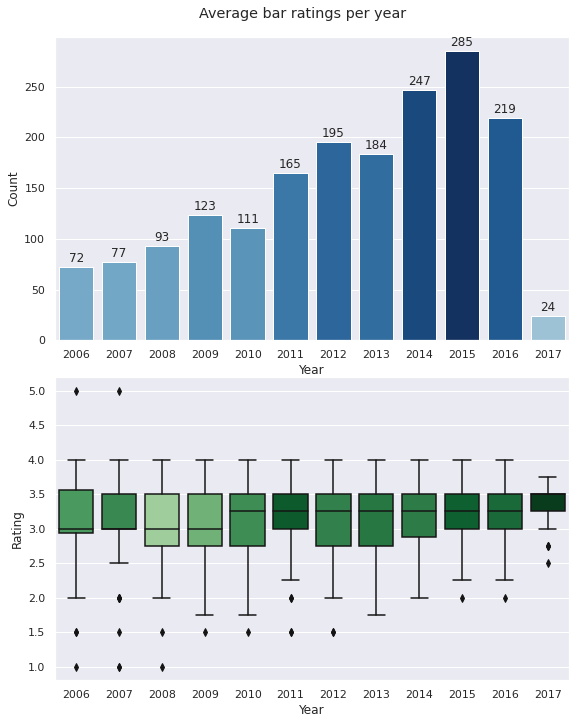

In [10]:
TITLE = 'Average bar ratings per year'

fig, ax = plt.subplots(2, 1, figsize=(8, 10))
fig.suptitle(TITLE)
fig.tight_layout()

palette = get_palette(ordered=True, val_list=list(chocodata['review_date'].value_counts().sort_index()))
sns.countplot(ax=ax[0], data=chocodata, x='review_date', palette=palette)
annotate_with_counts(ax[0])
rename_axes(ax[0], 'Year', 'Count')

palette = get_palette(ordered=True, alt_color=True, val_list=list(chocodata.groupby('review_date')['rating'].mean()))
sns.boxplot(ax=ax[1], data=chocodata, x='review_date', y='rating', palette=palette)
rename_axes(ax[1], 'Year', 'Rating')

save_plot(TITLE)

<a name="companies"></a>
## Companies

In this section, we collect a set of visualizations concerning company ratings.


<a name="comppercountry"></a>
### Companies per country


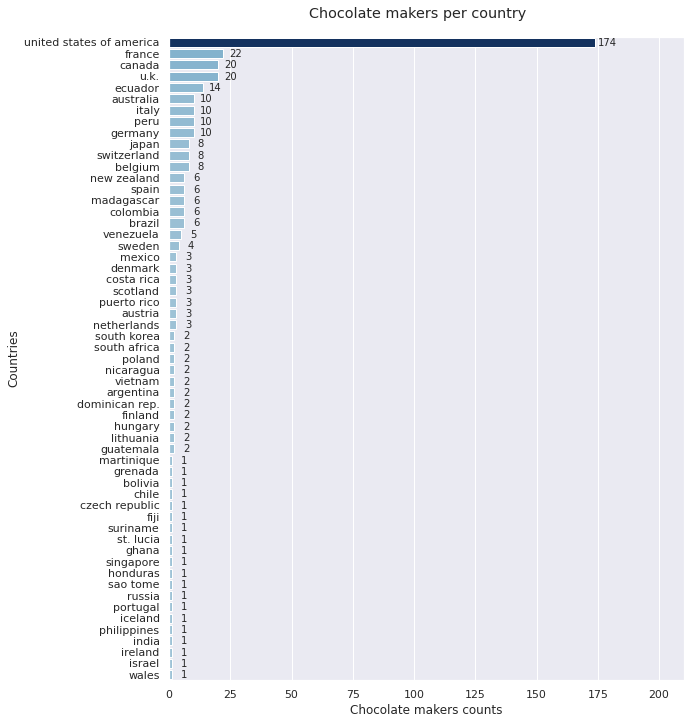

In [11]:
TITLE = 'Chocolate makers per country'

countries_companies = chocodata.drop_duplicates('company')
countries_counts = countries_companies.groupby(["company_location"]).size().reset_index(name='counts')
countries_counts = countries_counts.sort_values(by=['counts'], ascending=False)
min, max = countries_counts['counts'].min(), countries_counts['counts'].max()

fig, ax = plt.subplots(figsize=(8, 10))
fig.suptitle(TITLE)
fig.tight_layout()

palette = get_palette(ordered=True, val_list=list(countries_counts['counts']))
sns.barplot(ax=ax, data=countries_counts, x="counts", y="company_location", palette=palette)
ax.set_xlim((0, 210))
rename_axes(ax, 'Chocolate makers counts', 'Countries')
counts = []
for p in ax.patches:
    width = p.get_width()
    counts.append(width)
    plt.text(p.get_width()+5, p.get_y() + 0.55 * p.get_height(),
             '{:d}'.format(int(width)),
             ha='center', va='center').set_fontsize(10)

save_plot(TITLE, subfolder='companies')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator


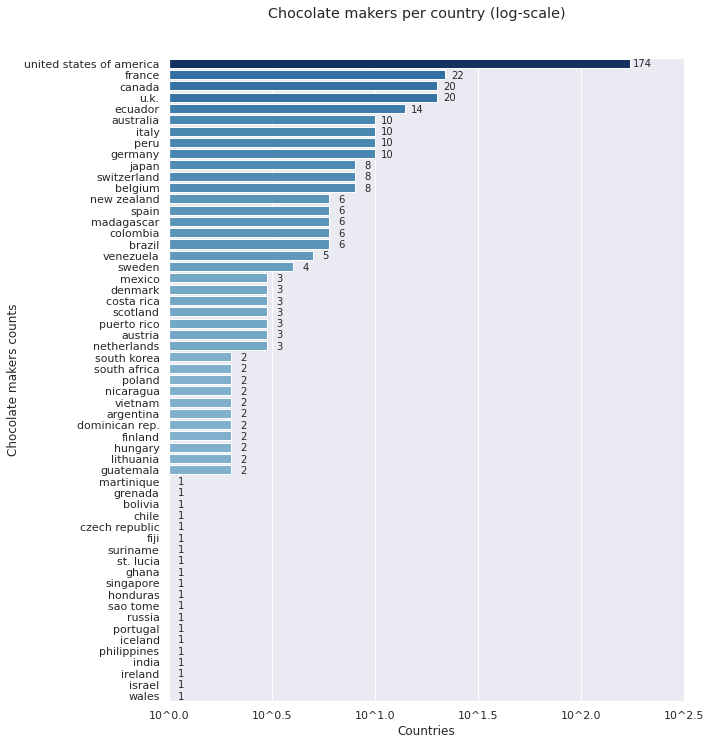

In [12]:
TITLE = 'Chocolate makers per country (log-scale)'

countries_companies = chocodata.drop_duplicates('company')
countries_counts = countries_companies.groupby(["company_location"]).size().reset_index(name='counts')
countries_counts = countries_counts.sort_values(by=['counts'], ascending=False)
counts_list = list(countries_counts['counts'])
countries_counts['counts'] = [np.log10(x) for x in counts_list]
counts_log_list = list(countries_counts['counts'])

min, max = np.min(counts_log_list), np.max(counts_log_list)

palette = get_palette(ordered=True, val_list=list(countries_counts['counts']))

fig, ax = plt.subplots(figsize=(8, 10))
fig.suptitle(TITLE, y=1.01)
fig.tight_layout()

#sns.kdeplot(ax=ax, data=countries_counts, x="counts", bw_adjust=.25)
#sns.histplot(ax=ax, data=countries_counts, x="counts", bins=100, palette=colormap)
#sns.countplot(ax=ax, data=countries_counts, x='counts', palette=palette)
sns.barplot(ax=ax, data=countries_counts, x="counts", y="company_location", palette=palette)
ax.set_xlim(0, 2.5)
#ax.grid(True, which="both")

i = 0
for p in ax.patches:
    plt.text(p.get_width() + 0.06, p.get_y() + 0.55 * p.get_height(),
             '{:d}'.format(int(counts[i])),
             ha='center', va='center').set_fontsize(10)
    i += 1

labels = ['10^{:.1f}'.format(n) for n in np.arange(0.0, 3.1, 0.5)]
ax.set_xticklabels(labels)
rename_axes(ax, 'Countries', 'Chocolate makers counts')

save_plot(TITLE, subfolder='companies')

<a name="mapcomp"></a>
### Map of the companies

In [13]:
# Import world map from geopandas
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world['name'] = world['name'].str.lower()

# Fix inconsistent name for ivory coast which uses non-ascii character
world.loc[(world['name'] == "côte d'ivoire"), 'name'] = "ivory coast"

# Merge company locations with world data and count companies per country

countries_companies = chocodata.drop_duplicates('company')
merge = countries_companies.merge(world, how='left', left_on=["company_location"], right_on=["name"])
company_location_counts = merge.groupby(["name"]).size().reset_index(name='counts')
counts_list = list(company_location_counts['counts'])
company_location_counts['log_counts'] = [np.log10(x) for x in counts_list]

# Compute binning for choropleth
min = company_location_counts['log_counts'].min()
max = company_location_counts['log_counts'].max()

bins = np.linspace(0, max, 7)
exp_bins = np.linspace(1, 10**max, 7)

# Initialize figure
fig = Figure(width=1500, height=800)

# Initialize choropleth map
map = folium.Map(location=[41, 12], zoom_start = 2, min_zoom=2)
cp = folium.Choropleth(
    geo_data=world,
    name="chocochoco",
    data=company_location_counts,
    bins=bins,
    columns=["name", "log_counts"],
    key_on="feature.properties.name",
    fill_color="Blues",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Chocolate making companies",
)

# Add popups to the map
for s in cp.geojson.data['features']:
    h = company_location_counts.loc[company_location_counts['name'] == s['properties']['name']]
    counts_list = list(h['counts'])
    if len(counts_list) > 0:
      country_count = counts_list[0]
      s['properties']['popup_info'] = 'Chocolate companies from {}: {}'.format(s['properties']['name'].title(), str(int(country_count)))
    else:
      s['properties']['popup_info'] = 'Chocolate companies from {}: {}'.format(s['properties']['name'].title(), 0)

folium.GeoJsonPopup(fields=['popup_info'], labels=False).add_to(cp.geojson)

# Remove legend as it is in quantile space
fig.add_child(map)
for key in cp._children:
    if key.startswith('color_map'):
        del(cp._children[key])

colormap = branca.colormap.linear.Blues_07.scale(1, 10**max)
colormap = colormap.to_step(index=exp_bins)
colormap.caption = 'Chocolate makers per country [click country to see the data]'
colormap.add_to(map)

cp.add_to(map)

# Show map
display(fig)

<a name="comprevs"></a>
### Companies per number of reviews


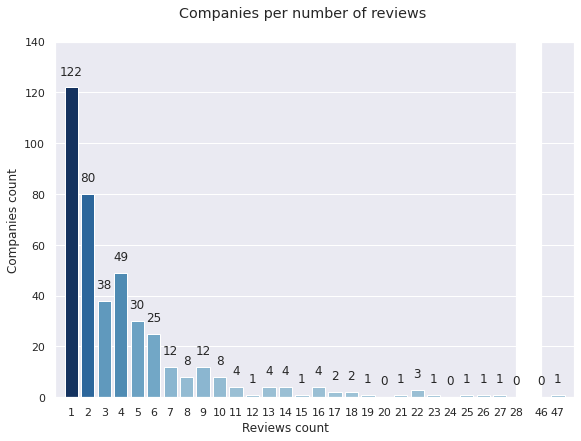

In [14]:
TITLE = 'Companies per number of reviews'

# Get a list of all the unique values of the company column
companies = chocodata_uniques['company']

# Get a list of all the unique values of the company_location column
countries = chocodata_uniques['company_location']

# Create a dictionary of the companies and their average evaluations
d = {'company': [],
     'avg_rating': [],
     'std_dev': [],
     'num_revs': []}

# For each company save its average evaluation in a dataframe
for c in companies:
    company_data = chocodata[chocodata.company == c]
    d['company'].append(c)
    d['avg_rating'].append(company_data['rating'].mean())
    d['std_dev'].append(company_data['rating'].std())
    d['num_revs'].append(company_data['ref'].count())

avg_companies = pd.DataFrame(d)

fig, (ax, ax2) = plt.subplots(1, 2, sharey=True, facecolor='w', figsize=(8, 6), gridspec_kw={'width_ratios': [28, 2]})
fig.suptitle(TITLE)
fig.tight_layout()

x = np.arange(np.min(avg_companies['num_revs'].unique()),
              np.max(avg_companies['num_revs'].unique()) + 1, 1)
y = [avg_companies[avg_companies['num_revs'] == i]['company'].count() for i in x]

palette = get_palette(ordered=True, val_list=y)
sns.barplot(ax=ax, data=avg_companies, x=x[:28], y=y[:28], palette=palette)
sns.barplot(ax=ax2, data=avg_companies, x=x, y=y, palette=palette)

ax.set_ylim((0, 140))
ax2.set_ylim((0, 140))

ax.set_xlim(-1, 27)
ax2.set_xlim(45, 47)

for p in ax.patches: 
    ax.annotate('{:d}'.format(int(p.get_height())), 
                (p.get_x() + p.get_width() * 0.5, p.get_height() + 5), 
                ha = 'center')
for p in ax2.patches: 
    ax2.annotate('{:d}'.format(int(p.get_height())), 
                 (p.get_x() + p.get_width() * 0.5, p.get_height() + 5), 
                 ha = 'center')

rename_axes(ax, 'Reviews count', 'Companies count')

save_plot(TITLE, subfolder='companies')

<a name="topcomp"></a>
### Top-rated companies

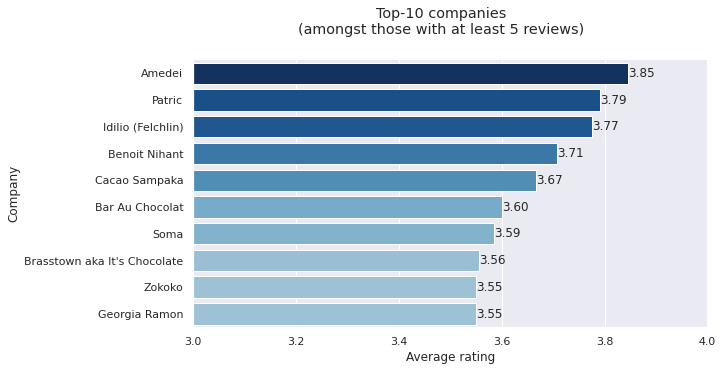

In [15]:
# Plot the N=10 best companies
TOP_COMPANIES = 10
# Drop all companies with less than N=5 reviews
MIN_NUM_OF_REVIEWS = 5

TITLE = 'Top-{} companies'.format(TOP_COMPANIES)
SUBTITLE = '\n(amongst those with at least {} reviews)'.format(MIN_NUM_OF_REVIEWS)

FULL_TITLE = TITLE+SUBTITLE


# Remove all the entries with too few bars
avg_companies = avg_companies.drop(
    avg_companies[avg_companies.num_revs < MIN_NUM_OF_REVIEWS].index)

# Extract the ten better companies in term of average chocolate rating
best_companies = avg_companies.nlargest(TOP_COMPANIES, 
                                        columns=['avg_rating'])

# Plot them through a horizontal barplot
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
fig.suptitle(FULL_TITLE)
fig.tight_layout()

palette = get_palette(ordered=True, val_list=list(best_companies['avg_rating']))

ax = sns.barplot(data=best_companies, x='avg_rating', y='company', 
                 palette=palette)
rename_axes(ax, 'Average rating', 'Company')
ax.bar_label(ax.containers[0], fmt='%.2f')
ax.set_xlim((3, 4))
sns.despine()

save_plot(TITLE, subfolder='companies')

<a name="bestcomp"></a>
### Best company per country

In [16]:
# Collect the best company for each country
t = {'country': [],
     'best_company': [],
     'avg_rating': []}

# For each country save its companies
for c in countries:
    companies_country = chocodata.loc[chocodata['company_location'] == c]
    # Create a dataframe in which to save the companies and their average evaluations
    d = {'company': [],
         'avg_rating': []}
    # For each company in country c, compute the average rating of its bars
    for comp in companies_country.company:
        # Compute the average rating for company comp of country c
        company_data = companies_country[companies_country.company == comp]
        d['company'].append(company_data['company'].values[0])
        d['avg_rating'].append(company_data['rating'].mean())
    avg_companies = pd.DataFrame(d)
    # Extract the best company for country c
    best_company = avg_companies.nlargest(1, ['avg_rating'])
    # Insert the company in the dataframe
    t['country'].append(c)
    t['best_company'].append(best_company['company'].values[0])
    t['avg_rating'].append(best_company['avg_rating'].values[0])

loc_companies = pd.DataFrame(t)
loc_companies = loc_companies.sort_values('country')

loc_companies

,country,best_company,avg_rating
15,argentina,Salgado,3.500000
26,australia,Matale,3.812500
20,austria,Zotter,3.308824
3,belgium,Benoit Nihant,3.708333
14,bolivia,El Ceibo,3.250000
22,brazil,Mission,3.625000
17,canada,Christopher Morel (Felchlin),3.750000
51,chile,Obolo,3.750000
5,colombia,Cacao Hunters,3.464286
31,costa rica,Sibu,3.375000


<a name="mapbestcomp"></a>
### Map of the best companies per country



In [18]:
# Mount drive to save images
#from google.colab import drive
#drive.mount('/content/drive')

SAVE_FIGURES = False

# Create a dataframe in which to save the best companies for each country
d = {'country': [],
     'best_company': [],
     'avg_rating': []}
loc_companies = pd.DataFrame(d)

# Create a dataframe to save the average rating of all bars of a country
d = {'country': [],
     'avg_rating': []}
country_avg_ratings = pd.DataFrame(d)

# Foreach country save its best companies
lines = []
txtfile = open("iminfo.txt", 'w')
for c in countries:
    companies_country = chocodata.loc[chocodata['company_location'] == c]
    mean_country_rating = companies_country['rating'].mean()
    d = {'country': [c], 'avg_rating': [mean_country_rating]}
    avg_country = pd.DataFrame(d)
    tmp = [country_avg_ratings, avg_country]
    country_avg_ratings = pd.concat(tmp)

    # Create a dataframe in which to save the companies and their average evaluations
    d = {'company': [], 'avg_rating': []}
    avg_companies = pd.DataFrame(d)

    # Foreach company in country c, compute the average rating of its bars
    for comp in pd.unique(companies_country.company):
        company = companies_country[companies_country.company == comp]
        mean_rating = company['rating'].mean()

        # Insert that company and its average rating inside the avg_companies dataframe
        d = pd.DataFrame(
            {'company': [comp],
             'avg_rating': [mean_rating]})
        tmp = [avg_companies, d]
        avg_companies = pd.concat(tmp)

    # Extract the top three companies for country c
    n_companies = 3
    best_company = avg_companies.nlargest(n_companies, ['avg_rating'])

    # Insert the company in the dataframe
    actual_n_companies = np.shape(best_company['company'].values)[0]
    country_rep_list = [c]*actual_n_companies
    company_list = best_company['company'].values
    rating_list = best_company['avg_rating'].values
    d = pd.DataFrame(
        {'country': country_rep_list,
         'best_company': company_list,
         'avg_rating': rating_list})
    tmp = [loc_companies, d]
    loc_companies = pd.concat(tmp, ignore_index=True)

    if SAVE_FIGURES:
      # Create a figure for each country to be used as a tooltip in the map
      sns.set(font_scale = 4)
      fig, axes = plt.subplots(actual_n_companies, 1, figsize=(20,8*actual_n_companies))
      fig.tight_layout(pad=3.0)
      fig.suptitle("Best companies in "+c, y=1.01)
      for i in range(actual_n_companies):
          company = companies_country[companies_country.company == company_list[i]]
          ax = sns.boxplot(ax=(axes[i] if actual_n_companies>1 else axes),y=company['company'], x=company['rating'], linewidth=2.5)
          ax.set(ylabel=None)
          ax.set(yticklabels=[])
          ax.set(xlim = (0,5))
          ax.set(title=company_list[i])

      # Save the figures in the images folder
      tosave = ax.get_figure()
      tosave.savefig(os.path.join(os.getcwd(), "/content/drive/MyDrive/colab/chocodata_images/best_companies_by_country/"+country_rep_list[0]+".png"), bbox_inches = 'tight')
      im = Image.open(os.path.join(os.getcwd(), "/content/drive/MyDrive/colab/chocodata_images/best_companies_by_country/"+country_rep_list[0]+".png"))
      lines.append(country_rep_list[0]+","+str(im.size[0])+","+str(im.size[1])+"\n")

if SAVE_FIGURES:
  # Save the helper file that will be used to build the html
  txtfile.writelines(lines)
  txtfile.close()
  loc_companies.set_index('country')
  loc_companies.sort_values('country')
  sns.set(font_scale = 1)

%matplotlib inline


In [19]:
# Merge world data with the best companies data
merge = country_avg_ratings.merge(world, how='left', left_on=["country"], right_on=["name"])
ratings = [x for x in merge['avg_rating']]
min = merge['avg_rating'].min()
max = merge['avg_rating'].max()

bins = np.linspace(min, max, 7)

# Initialize figure
fig = Figure(width=1500, height=800)

# Initialize choropleth map
map = folium.Map(location=[41, 12], zoom_start = 2, min_zoom=2)
cp = folium.Choropleth(
    geo_data=world,
    name="chocochoco",
    data=merge,
    bins=bins,
    columns=["name", "avg_rating"],
    key_on="feature.properties.name",
    fill_color="Blues",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Mean chocolate ratings by country and best companies",
)

#!wget /html_dic.txt "https://drive.google.com/uc?export=view&id=1gWIFCQsFIt8aI4xwI_FaGdFRkVWiCl_e"
html_dic_file = open("html_dic.txt", 'rb')
html_dic = pickle.load(html_dic_file)

# Add popups to the map
for s in cp.geojson.data['features']:
  s['properties']['popup_html'] = html_dic[s['properties']['name']]

# html_dic_file = open("/content/drive/MyDrive/colab/chocodata_images/best_companies_by_country/html_dic.txt", 'wb')
# html_dic = {}

# # Add popups to the map
# for s in cp.geojson.data['features']:
#   html = html_country(s['properties']['name'])
#   s['properties']['popup_html'] = html
#   html_dic[s['properties']['name']] = html

# import pickle
# pickled_dic = pickle.dumps(html_dic)
# html_dic_file.write(pickled_dic)
# html_dic_file.close()

folium.GeoJsonPopup(fields=['popup_html'], labels=False).add_to(cp.geojson)

# Remove legend as it is in quantile space
fig.add_child(map)
for key in cp._children:
    if key.startswith('color_map'):
        del(cp._children[key])

colormap = branca.colormap.linear.Blues_07.scale(min, max)
colormap = colormap.to_step(index=bins)
colormap.caption = 'Average chocolate rating [click country to see best companies]'
colormap.add_to(map)

cp.add_to(map)

# Show map
display(fig)

<a name="cocoa"></a>
## Cocoa beans

In this section, we collect a set of visualizations concerning cocoa beans ratings and cocoa percentage ratings. 

<a name="beandistrib"></a>
### Bean types distribution

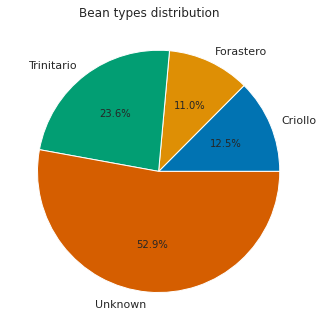

In [20]:
TITLE = 'Bean types distribution'

chocodata_beans = chocodata.sort_values(by='bean_type')
bean_counts = chocodata_beans.groupby('bean_type').size().reset_index(
    name='counts')

fig, ax = plt.subplots(1, 1, figsize=[5, 6])
fig.tight_layout()
plt.pie(x=bean_counts['counts'], 
        autopct="%.1f%%", 
        labels=bean_counts['bean_type'],
        colors=get_palette(4))
fig.suptitle(TITLE, y=0.9)

save_plot(TITLE, subfolder='cocoa_beans')

<a name="ratingsbean"></a>
### Ratings per bean type


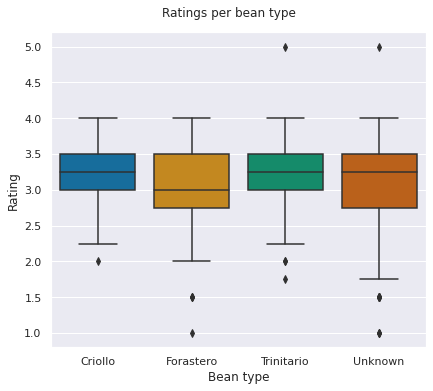

In [21]:
TITLE = 'Ratings per bean type'

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
fig.tight_layout()
fig.suptitle(TITLE, y=1.03)
sns.boxplot(ax=ax, 
            data=chocodata_beans, 
            x='bean_type', 
            y='rating', 
            palette=get_palette(4))
rename_axes(ax, 'Bean type', 'Rating')

save_plot(TITLE, subfolder='cocoa_beans')

<a name="reviewsperc"></a>
### Reviews per cocoa percent

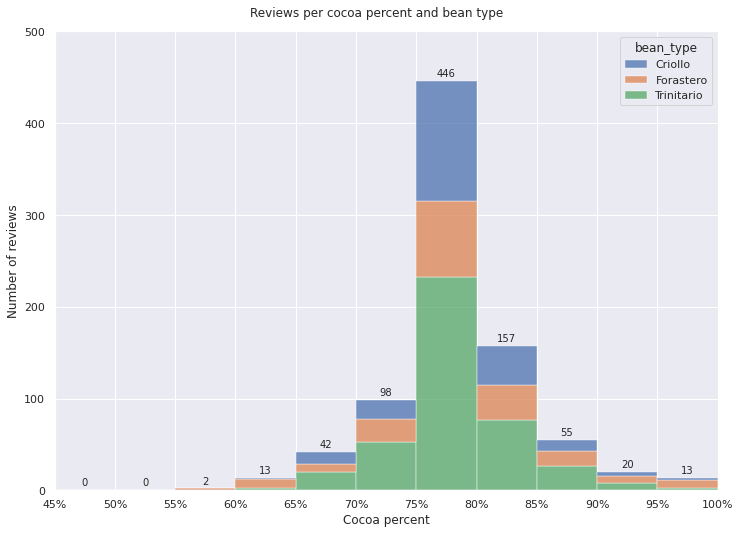

In [22]:
TITLE = 'Reviews per cocoa percent and bean type'

# >>>  Set this to True in order to plot the counts for unknown bean types  <<<
PLOT_UNK = False

beans = 4 if PLOT_UNK else 3

# Control the aggregation precision
STEP = 0.05
assert STEP >= 0.05, "Aggregation too thin!"

# Define a new dataframe with aggregated percentages
percentages = np.arange(1.0, 0.40, -STEP)
d = {'perc': [], 'rating': [], 'bean_type': []}
_chocodata = chocodata if PLOT_UNK else chocodata[chocodata['bean_type'] != 'Unknown']
for bar in _chocodata.iterrows():
    bar = bar[1]
    for p in percentages:
        if p >= bar['cocoa_percent'] > p - STEP:
            d['perc'].append(p)
            d['rating'].append(bar['rating'])
            d['bean_type'].append(bar['bean_type'])
perc_ratings = pd.DataFrame(d).sort_values(by=['bean_type', 'perc'])

percentages = percentages[::-1]

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
fig.tight_layout()
fig.suptitle(TITLE, y=1.02)

palette = get_palette(beans)
sns.histplot(ax=ax, data=perc_ratings, x='perc', hue='bean_type', multiple='stack', 
             bins=percentages, linewidth=0.4)
rename_axes(ax, 'Cocoa percent', 'Number of reviews')

bars = int(len(ax.patches) / beans)
tot_h = [0] * bars
for i in range(bars):
    for j in range(beans):
        tot_h[i] += int(ax.patches[j * bars + i].get_height())

for i in range(bars):
    p = ax.patches[i + (beans - 1) * bars]
    ax.annotate('{:d}'.format(tot_h[i]), 
                (p.get_x() + p.get_width() * 0.5, tot_h[i]+5), 
                ha = 'center')

ax.set_xticks(percentages)
ax.set_xticklabels([str(i) + '%' for i in range(45, 101, int(STEP * 100))])
ax.set_ylim((0, 1100 if PLOT_UNK else 500))
ax.set_xlim((0.45,1.0))

save_plot(TITLE, subfolder='cocoa_beans')

<a name="ratingsperc"></a>
### Ratings per cocoa percent

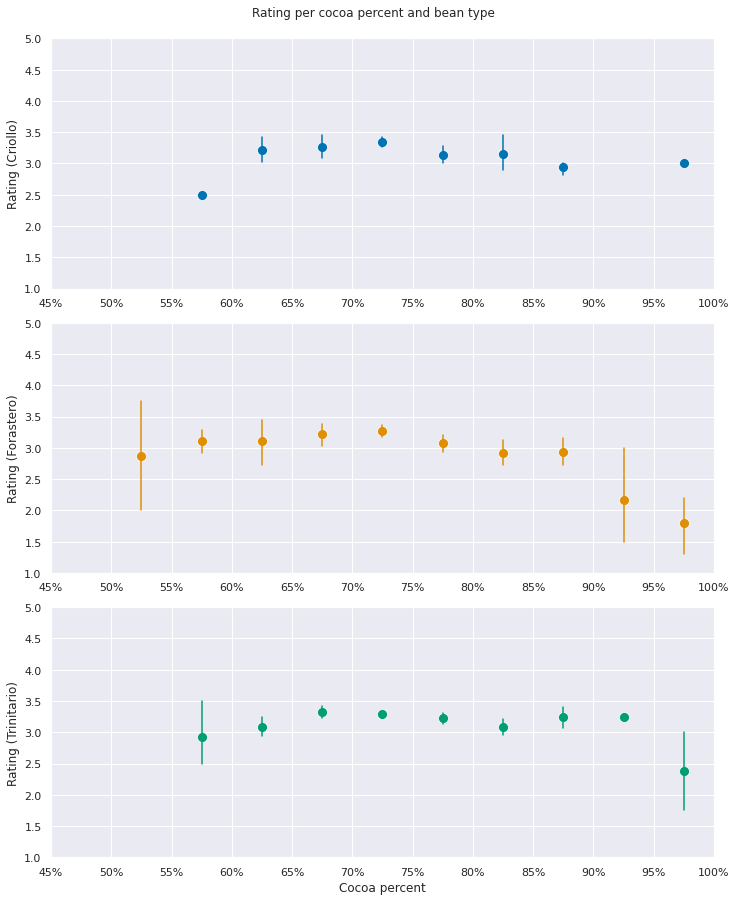

In [23]:
TITLE = 'Rating per cocoa percent and bean type'

fig, ax = plt.subplots(beans, 1, figsize=(10, 4 * beans))
fig.tight_layout()
fig.suptitle(TITLE, y=1.02)

beans_list = ['Criollo', 'Forastero', 'Trinitario', 'Unknown']

mid_percentages = np.arange(0.475, 1.0 + STEP, STEP)
mid_labels = ['{}%'.format(str(i)) for i in range(45, 101, int(STEP * 100))]

for i in range(beans):
    sns.lineplot(
        ax=ax[i],
        data=perc_ratings[perc_ratings['bean_type'] == beans_list[i]],
        x='perc', 
        y='rating',
        color=get_palette(beans)[i],
        marker='o', linestyle='', err_style='bars', markersize=10,
    )
    ax[i].set_ylim((1, 5))
    rename_axes(ax[i], '', 'Rating ({})'.format(beans_list[i]))
    ax[i].set_xticks(mid_percentages)
    ax[i].set_xticklabels(mid_labels)

rename_axes(ax[beans - 1], 'Cocoa percent', 'Rating ({})'.format(beans_list[beans - 1]))
save_plot(TITLE, subfolder='cocoa_beans')

<a name="beanimports"></a>
### Bean imports by country


In [24]:
# Compute centroids of all countries for line drawing
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world['name'] = world['name'].str.lower()

cp = folium.Choropleth(
    geo_data=world,
    name="chocochoco",
    data=merge,
    columns=["name", "avg_rating"],
    key_on="feature.properties.name",
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Mean chocolate ratings by country",
)

countries_centroids = {}
for feature in cp.geojson.data['features']:
    name = feature['properties']['name']
    centroid = shape(feature["geometry"]).centroid
    countries_centroids[name] = centroid

# Dropdown menu for country selection
importing_countries = list(chocodata.company_location.unique())

country_select = widgets.Dropdown(
    options=importing_countries,
    value='italy',
    description='Select country to visualize cocoa imports:',
    disabled=False,
)
display(country_select)

Dropdown(description='Select country to visualize cocoa imports:', index=6, options=('united states of america…

In [25]:
# Create list of imports for the specified country
imports = chocodata.loc[(chocodata['company_location'] == country_select.value)]
imports_origin_type = list(zip(imports['bean_type'], imports['bean_origin']))
imports_origin_type = [x for x in imports_origin_type if x[0]!= 'Unknown' and x[1]!= 'Unknown']

# Initialize map
fig = Figure(width=1500, height=800)
map = folium.Map(location=[41, 12], zoom_start = 2, min_zoom=2)
fig.add_child(map)

# Initialize bean type palette
p = get_palette(3)
palette = {}
palette['Trinitario'] = p[2]
palette['Forastero'] = p[1]
palette['Criollo'] = p[0]

# Add lines
def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

importing_country_centroid = countries_centroids[country_select.value]

for elem in imports_origin_type:
  bean_type = elem[0]
  bean_origin = elem[1]
  try:
    exporting_country_centroid = countries_centroids[bean_origin]
  except:
    continue

  # Jitter line coordinates based on bean type
  jitter_distance = 0.2

  line_start = [exporting_country_centroid.x, exporting_country_centroid.y]
  line_end = [importing_country_centroid.x, importing_country_centroid.y]

  perp_vector = np.array([-line_end[1]+line_start[1], line_end[0]-line_start[0]])
  perp_vector = perp_vector/np.linalg.norm(perp_vector)

  perp_x = perp_vector[0]*jitter_distance
  perp_y = perp_vector[1]*jitter_distance

  if bean_type == 'Forastero':
    line_start[0] += perp_x
    line_start[1] += perp_y
    line_end[0] += perp_x
    line_end[1] += perp_y
  elif bean_type == 'Trinitario':
    line_start[0] -= perp_x
    line_start[1] -= perp_y
    line_end[0] -= perp_x
    line_end[1] -= perp_y


  # Color based on type
  color = tuple((np.array(palette[bean_type])*255).astype(np.uint8))

  # Add line
  folium.PolyLine(locations=[line_start[::-1], line_end[::-1]], color=rgb_to_hex(color), weight=1).add_to(map)

# Create legend
legend_html = '''
  {% macro html(this, kwargs) %}
  <div style="
      position: fixed; 
      bottom: 50px;
      left: 50px;
      width: 250px;
      height: 80px;
      z-index:9999;
      font-size:14px;
      ">
      <p><a style="color:#0173b2;font-size:150%;margin-left:20px;">&diams;</a>&emsp;Criollo</p>
      <p><a style="color:#de8f05;font-size:150%;margin-left:20px;">&diams;</a>&emsp;Forastero</p>
      <p><a style="color:#029e73;font-size:150%;margin-left:20px;">&diams;</a>&emsp;Trinitario</p>
  </div>
  <div style="
      position: fixed; 
      bottom: 10px;
      left: 50px;
      width: 150px;
      height: 120px; 
      z-index:9998;
      font-size:14px;
      background-color: #ffffff;

      opacity: 0.7;
      ">
  </div>
  {% endmacro %}
  '''
legend = branca.element.MacroElement()
legend._template = branca.element.Template(legend_html)
map.get_root().add_child(legend)

# Display map
display(fig)

<a name="beanexports"></a>
### Top-rated bean exporters

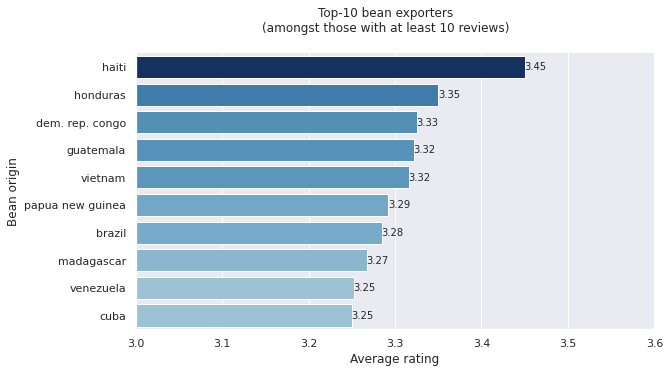

In [26]:
# Plot the N=10 top countries
TOP_COUNTRIES = 10
# Drop all countries with less than N=10 reviews
MIN_NUM_OF_REVIEWS = 10

TITLE = 'Top-{} bean exporters'.format(TOP_COUNTRIES)
SUBTITLE = '\n(amongst those with at least {} reviews)'.format(MIN_NUM_OF_REVIEWS)
FULL_TITLE = TITLE+SUBTITLE

# Get a list of all the unique cocoa bean origins
b_origins = chocodata_uniques['bean_origin']

# Create the dictionary with the average grades with respect to the bean origin
d = {'bean_origin': [],
      'avg_rating': [],
      'num_revs':[]}

# Forveach bean type, compute its average evaluation
for o in b_origins:
    origin_data = chocodata[chocodata.bean_origin == o]
    d['bean_origin'].append(o)
    d['avg_rating'].append(origin_data['rating'].mean())
    d['num_revs'].append(origin_data['ref'].count())

# Convert the dictionary into a DataFrame
avg_bean_origin = pd.DataFrame(d)

# Remove all the grades linked to an unknown bean type
avg_bean_origin = avg_bean_origin[avg_bean_origin.bean_origin != 'Unknown']

# Remove all the entries with too few bars
avg_bean_origin = avg_bean_origin.drop(
    avg_bean_origin[avg_bean_origin.num_revs < MIN_NUM_OF_REVIEWS].index)

# Extract the 10 better bean types, in terms of average rating
best_countries = avg_bean_origin.nlargest(TOP_COUNTRIES, columns=['avg_rating'])

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
fig.suptitle(FULL_TITLE)
fig.tight_layout()

palette = get_palette(ordered=True, val_list=list(best_countries['avg_rating']))
ax = sns.barplot(data=best_countries, 
                 x='avg_rating', 
                 y='bean_origin', 
                 palette=palette)
rename_axes(ax, 'Average rating', 'Bean origin')
ax.bar_label(ax.containers[0], fmt='%.2f')
ax.set_xlim((3, 3.6))
sns.despine()

save_plot(TITLE, subfolder='cocoa_beans')